In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
# import dask.dataframe as dd


In [2]:
# from dask.distributed import Client
# client = Client(memory_limit='10GB')  # Tăng giới hạn bộ nhớ
# # client.close()


In [3]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp1"
os.makedirs(save_dir, exist_ok=True)
ndays=1

In [4]:
df_train = pd.read_csv(f'{save_dir}/df_train{ndays}_days_pre_processing.csv', index_col=None)
df_valid = pd.read_csv(f'{save_dir}/df_valid{ndays}_days_pre_processing.csv', index_col=None)



In [5]:
df_train=df_train.drop(columns=['Unnamed: 0'])
df_valid=df_valid.drop(columns=['Unnamed: 0'])


In [6]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_valid = df_valid.drop('target', axis=1)
y_valid = df_valid['target']

In [7]:

X_train.to_csv(f'{save_dir}/X_train_train_lag{ndays}_days_pre_processing.csv')
X_valid.to_csv(f'{save_dir}/X_valid_train_lag{ndays}_days_pre_processing.csv')
y_train.to_csv(f'{save_dir}/y_train_train_lag{ndays}_days_pre_processing.csv')
y_valid.to_csv(f'{save_dir}/y_valid_train_lag{ndays}_days_pre_processing.csv')

Evaluating LR...
neg_mean_absolute_error LR: -0.316 (0.014)
r2 LR: 0.526 (0.044)
Evaluating Ridge...
neg_mean_absolute_error Ridge: -0.316 (0.014)
r2 Ridge: 0.527 (0.044)
Evaluating Lasso...
neg_mean_absolute_error Lasso: -0.286 (0.017)
r2 Lasso: 0.406 (0.027)
Evaluating DT...
neg_mean_absolute_error DT: -0.061 (0.005)
r2 DT: 0.945 (0.008)
Evaluating RF...
neg_mean_absolute_error RF: -0.047 (0.004)
r2 RF: 0.972 (0.004)
Evaluating GBR...
neg_mean_absolute_error GBR: -0.247 (0.010)
r2 GBR: 0.783 (0.033)
Evaluating LGBM...
neg_mean_absolute_error LGBM: -0.056 (0.003)
r2 LGBM: 0.973 (0.004)
Evaluating SVR...
neg_mean_absolute_error SVR: -0.441 (0.025)
r2 SVR: -0.405 (0.135)


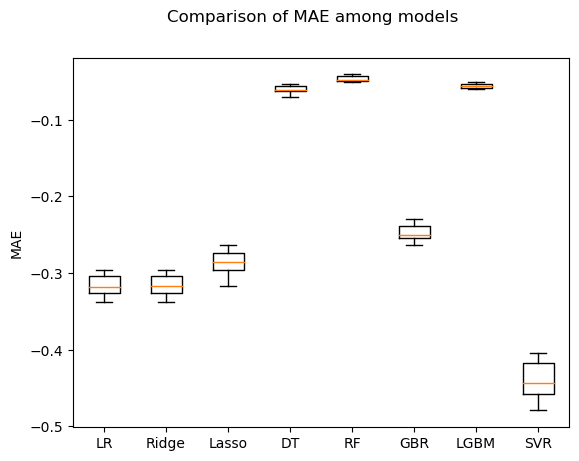

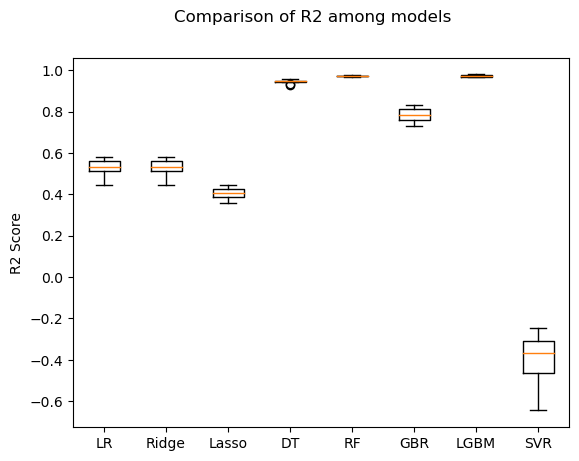

In [8]:


num_folds = 10
seed = 7
scorers = {'mae': make_scorer(mean_absolute_error), 'r2': make_scorer(r2_score)}
models = []

# Defining models
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge(alpha=1.0)))
models.append(('Lasso', Lasso(alpha=0.1)))
models.append(('DT', DecisionTreeRegressor(random_state=42)))
models.append(('RF', RandomForestRegressor(n_estimators=100, random_state=42)))
models.append(('GBR', GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)))
models.append(('LGBM', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=100, verbose=-1)))
models.append(('SVR', SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)))

# Function to evaluate models
def check_model(name, model, X, y, scoring):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    msg = f"{scoring} {name}: {cv_results.mean():.3f} ({cv_results.std():.3f})"
    print(msg)
    return cv_results

results_mae = []
names_mae = []
results_r2 = []
names_r2 = []

# Evaluating models
for name, model in models:
    print(f"Evaluating {name}...")
    mae_result = check_model(name, model, X_valid, y_valid, scoring='neg_mean_absolute_error')
    results_mae.append(mae_result)
    names_mae.append(name)
    
    r2_result = check_model(name, model, X_valid, y_valid, scoring='r2')
    results_r2.append(r2_result)
    names_r2.append(name)

# Plotting MAE
fig_mae = plt.figure()
fig_mae.suptitle('Comparison of MAE among models')
ax_mae = fig_mae.add_subplot(111)
plt.boxplot(results_mae)
ax_mae.set_xticklabels(names_mae)
plt.ylabel('MAE')
plt.show()

# Plotting R2
fig_r2 = plt.figure()
fig_r2.suptitle('Comparison of R2 among models')
ax_r2 = fig_r2.add_subplot(111)
plt.boxplot(results_r2)
ax_r2.set_xticklabels(names_r2)
plt.ylabel('R2 Score')
plt.show()
